In [251]:
# Load the dataset
import pandas as pd
import numpy as np

df = pd.read_csv('pets_prepared.csv')
df.head()

,PetID,AdoptionSpeed,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,HealthName,VaccinatedName,DewormedName,SterilizedName,BreedName,BreedBinsName,StateName,StateBinsName,ColorName,AdoptedName
0,86e1089a3,2,2,Nibble,3,299,0,1,1,7,...,Healthy,No,No,No,Tabby,Tabby,Selangor,Selangor,Black,Y
1,6296e909a,0,2,No Name Yet,1,265,0,1,1,2,...,Healthy,Not Sure,Not Sure,Not Sure,Domestic Medium Hair,Domestic Medium Hair,Kuala Lumpur,Kuala Lumpur,Black,Y
2,3422e4906,3,1,Brisco,1,307,0,1,2,7,...,Healthy,Yes,Yes,No,Mixed Breed,Mixed Breed,Selangor,Selangor,Brown,Y
3,5842f1ff5,2,1,Miko,4,307,0,2,1,2,...,Healthy,Yes,Yes,No,Mixed Breed,Mixed Breed,Kuala Lumpur,Kuala Lumpur,Black,Y
4,850a43f90,2,1,Hunter,1,307,0,1,1,0,...,Healthy,No,No,No,Mixed Breed,Mixed Breed,Selangor,Selangor,Black,Y


In [252]:
# Investigate the nature of data in a few columns
df['AgeBins'].value_counts()

[  3,  6)    3670
2            3503
[  0,  2)    2483
[ 24, 60)    1601
[  6, 12)    1588
[ 12, 24)    1557
[ 60,255]     591
Name: AgeBins, dtype: int64

In [253]:
mask = df['AgeBins'] == '2'
print(df.loc[mask, 'Age'].value_counts())
all_age_2 = (df.loc[mask, 'Age'] == 2).all()

print(all_age_2)

# Seems strange there are so many pets in the '2' category, but they are not wrongly classified

2    3503
Name: Age, dtype: int64
True


In [254]:
df['BreedBins'].value_counts()

307       5927
266       3634
Others    3272
265       1258
299        342
264        296
292        264
Name: BreedBins, dtype: int64

In [255]:
df[['BreedBins', 'BreedName']].head(50)

# 307 corresponds with Mixed Breed
# All the less common breeds are grouped together in the 'Other' category
# We may want to encode the less common breeds as well depending on the entropy of the column

,BreedBins,BreedName
0,299,Tabby
1,265,Domestic Medium Hair
2,307,Mixed Breed
3,307,Mixed Breed
4,307,Mixed Breed
5,266,Domestic Short Hair
6,264,Domestic Long Hair
7,307,Mixed Breed
8,265,Domestic Medium Hair
9,265,Domestic Medium Hair


In [256]:
# Investigate the frequency of the "Breed1" column
df['Breed1'].value_counts()

307    5927
266    3634
265    1258
299     342
264     296
       ... 
176       1
214       1
125       1
123       1
81        1
Name: Breed1, Length: 176, dtype: int64

In [257]:
# Investigate the frequency of the "Breed2" column
df['Breed2'].value_counts()

0      10762
307     1727
266      599
265      321
299      138
       ...  
104        1
36         1
17         1
257        1
279        1
Name: Breed2, Length: 135, dtype: int64

In [258]:
# The number of unique values in the "Breed1" and "Breed2" columns is quite high. 
# I suspect that Breed can be encompassed by FurLength and BreedPure since majority of pets 
# are mixed breed or domestic

In [259]:
# Change all columns into categorical columns
y = df['AdoptionSpeed']

# Column 32 onwards are all derived values or labels which have already been encoded
# We will keep BreedPure, ColorAmt and NameorNO though because the information may be lost when we remove the original columns
x = df.iloc[:,:34].drop('AdoptionSpeed', axis=1)

# We may deal with these columns later, they are difficult to encode/likely not useful for analysis
x = x.drop(['PetID', 'Name', 'Description', 'RescuerID'], axis=1)

# Remove numerical columns because they have been binned
x = x.drop(['Breed1', 'Breed2', 'Age', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt'], axis=1)

# Find columns with missing values
x.isnull().sum()

# No missing values!

Type            0
Gender          0
Color1          0
Color2          0
Color3          0
MaturitySize    0
FurLength       0
Vaccinated      0
Dewormed        0
Sterilized      0
Health          0
AgeBins         0
FeeBins         0
BreedBins       0
StateBins       0
VideoAmtBins    0
PhotoAmtBins    0
QuantityBins    0
BreedPure       0
ColorAmt        0
NameorNO        0
dtype: int64

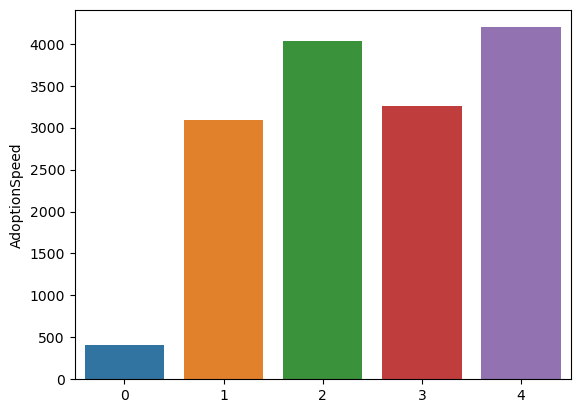

In [260]:
# Visualise distribution of the target AdoptionSpeed variable
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=y.value_counts().index, y=y.value_counts())
plt.show()

c:\Users\shaol\anaconda3\envs\CS2109S\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


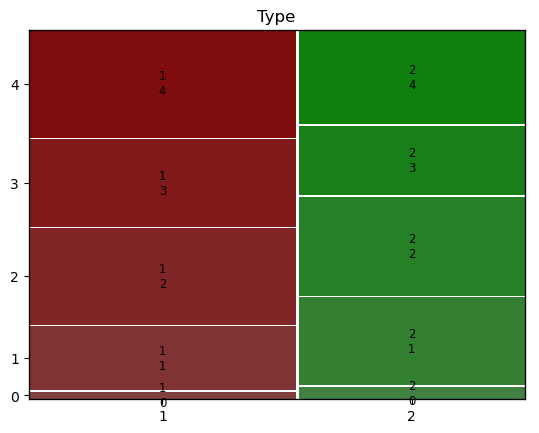

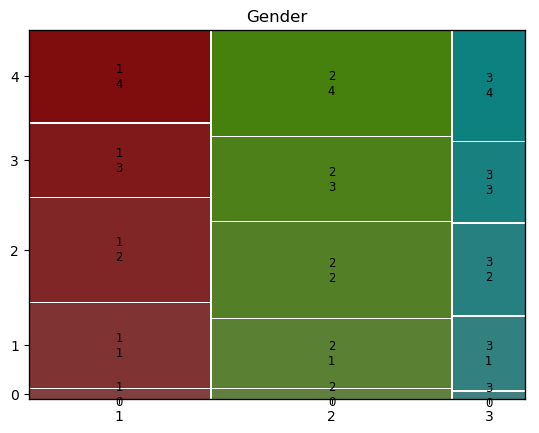

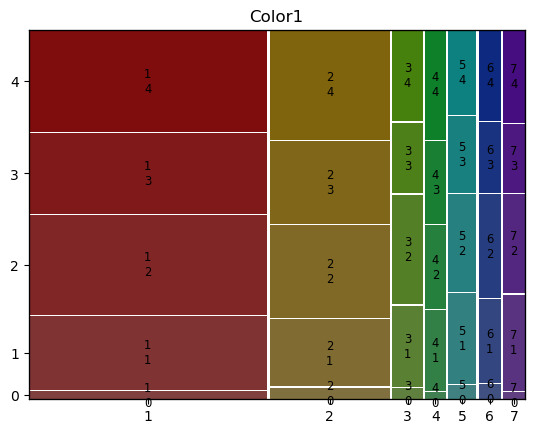

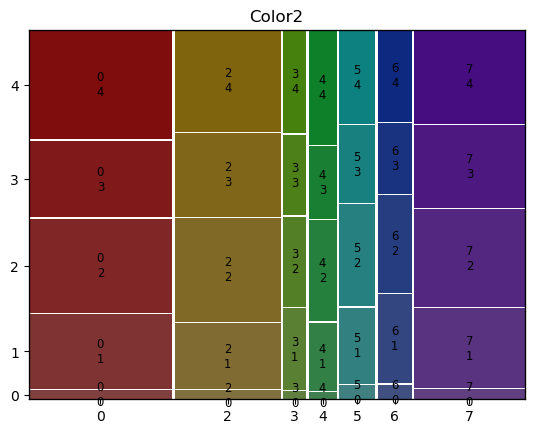

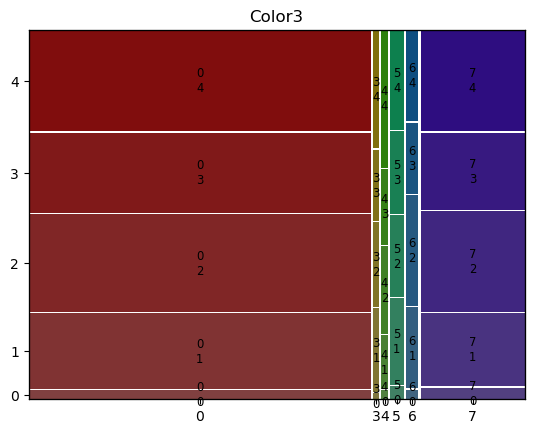

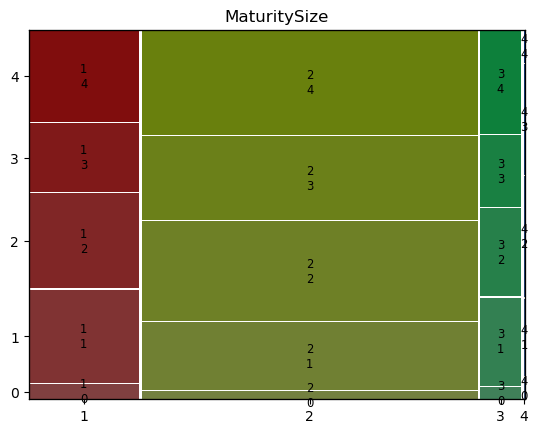

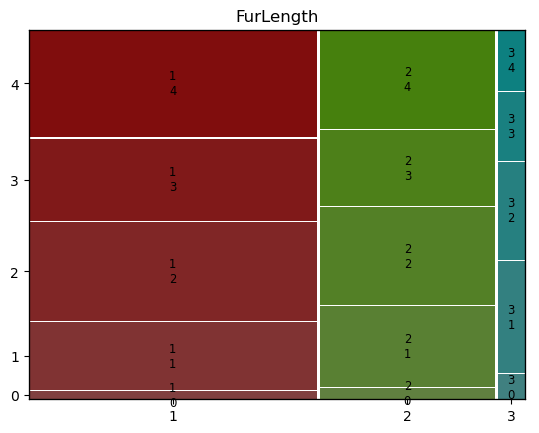

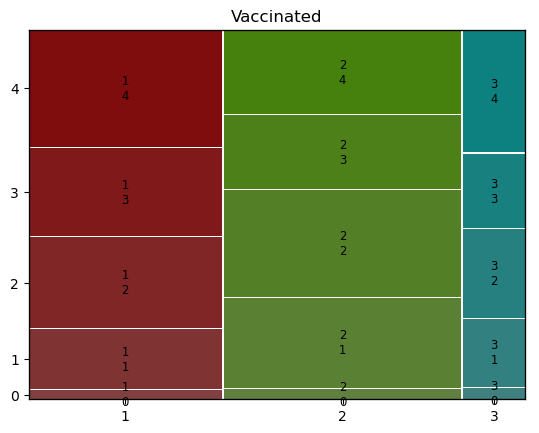

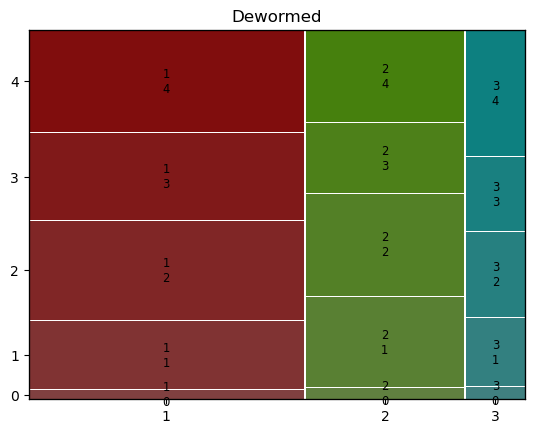

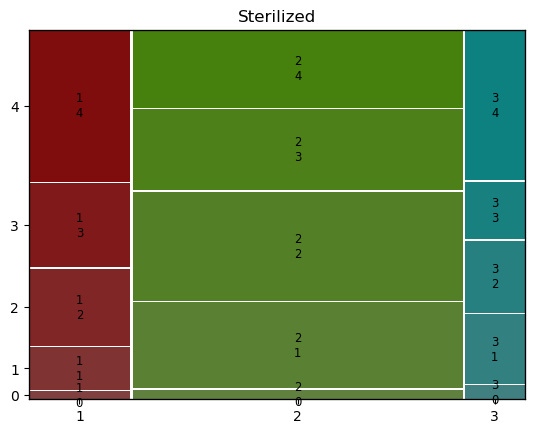

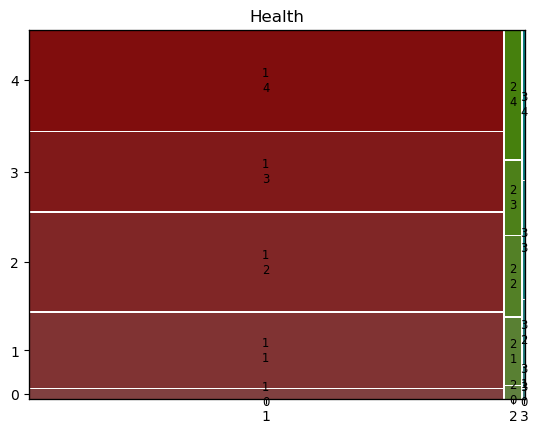

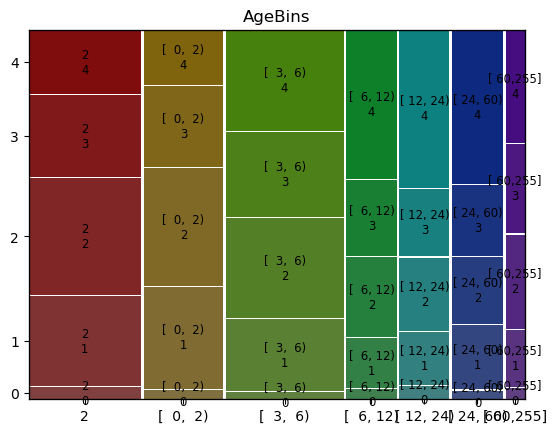

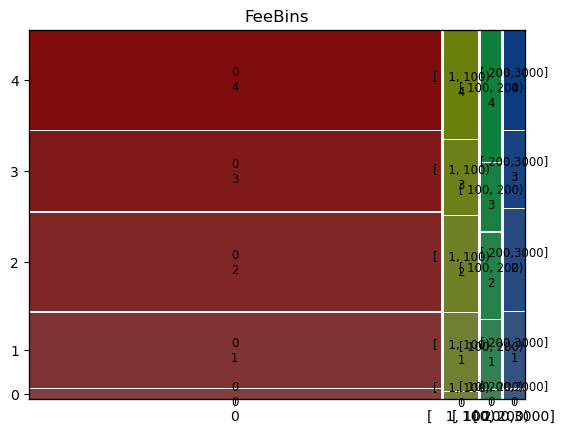

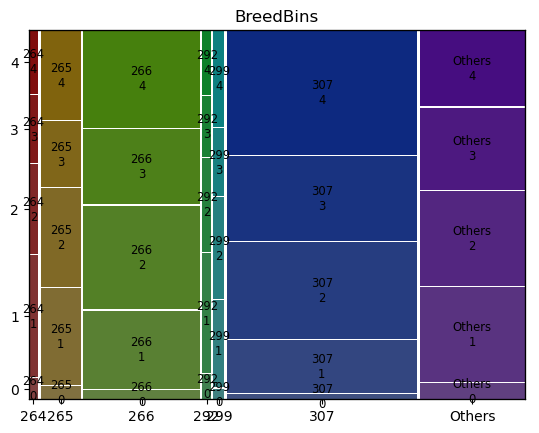

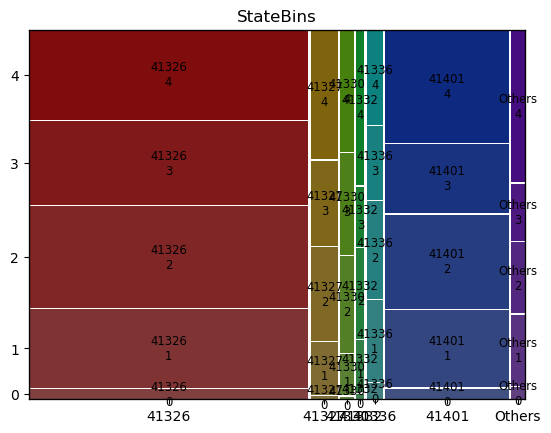

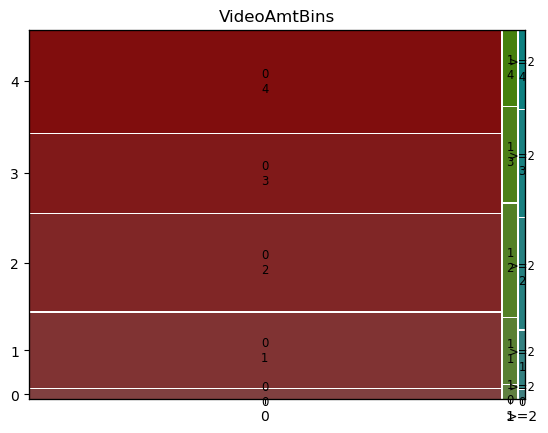

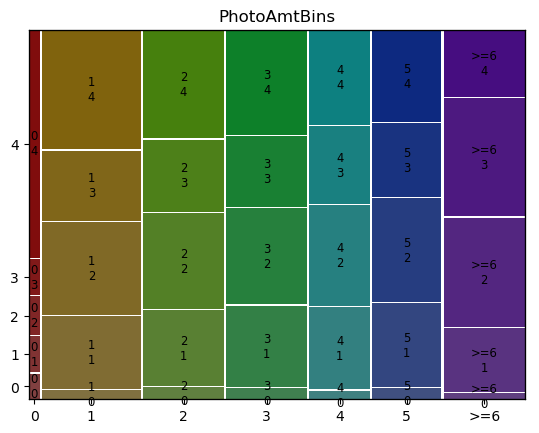

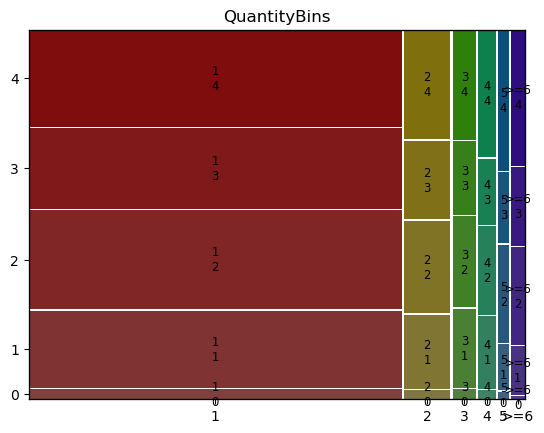

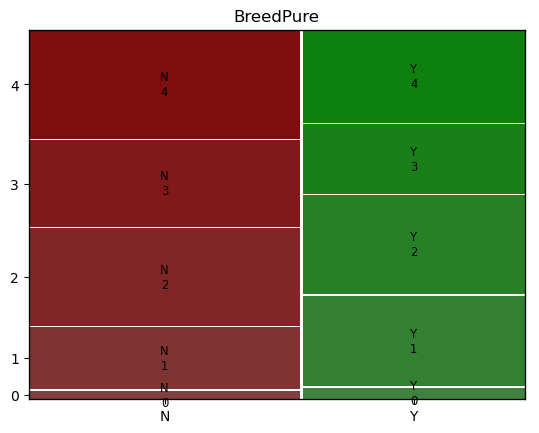

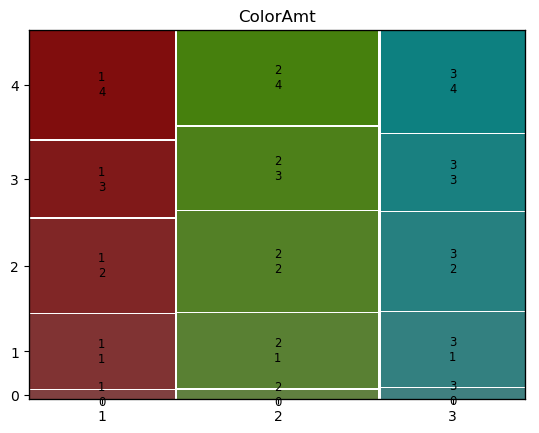

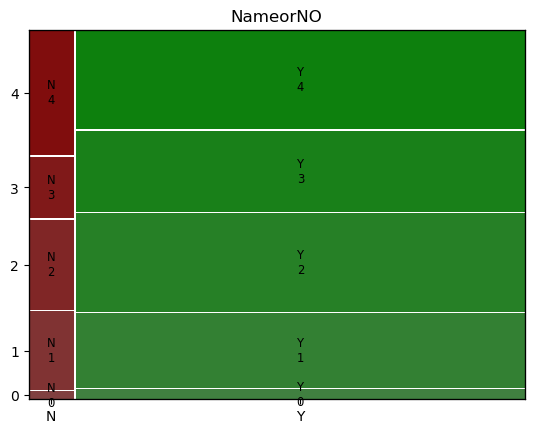

In [261]:
# Visualise each column against the target AdoptionSpeed variable
from statsmodels.graphics.mosaicplot import mosaic

for column in x.columns:
    # Sort the DataFrame
    df_sorted = df.sort_values(by=['AdoptionSpeed', column])
    mosaic(df_sorted, [column, 'AdoptionSpeed'], title=column)

<AxesSubplot:>

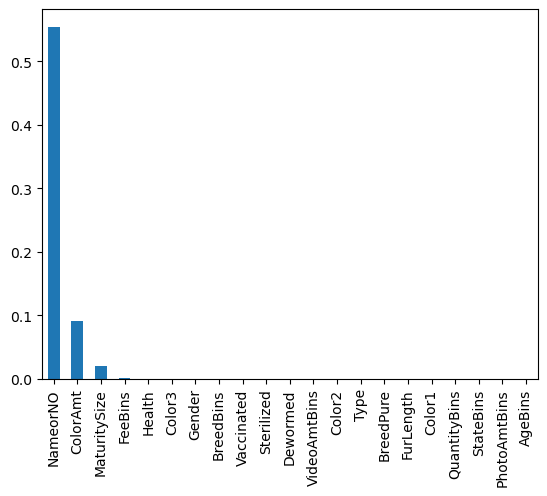

In [262]:
# Test which columns are significant

from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder

# Split into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Ordinal encoding assumes that the data is ordinal, which is not the case for most columns in this dataset
# However, this should be fine for the chi-squared test, which ignores the ordinal nature of the data
# The chi-squared test is used to determine if two categorical variables are independent
# If a column is independent of the target variable, it suggests that it is not useful for prediction

x_ordinal = x_train.copy()
oe = OrdinalEncoder()
x_ordinal = oe.fit_transform(x_ordinal)

chi_scores = chi2(x_ordinal, y_train)
p_values = pd.Series(chi_scores[1],index = x.columns)
p_values.sort_values(ascending = False , inplace = True)

# Plot the p-values
p_values.plot.bar()

# It seems like we can drop the NameorNO and ColorAmt columns

In [263]:
# Test independence between BreedPure and BreedBins
from scipy.stats import chi2_contingency

contingency = pd.crosstab(x_train['BreedBins'], x_train['BreedPure'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(chi2, p)

# Test independence between FurLength and BreedBins
contingency = pd.crosstab(x_train['BreedBins'], x_train['FurLength'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(chi2, p)

# The columns are not independent as ex_trainpected, especially since BreedPure is derived from the Breed

# Test independence between BreedPure and FurLength
contingency = pd.crosstab(x_train['FurLength'], x_train['BreedPure'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(chi2, p)

# Actually, the columns are independent! In this case, let's keep all of them.

7256.688658336328 0.0
4802.6120231857485 0.0
87.42699401226184 1.036261744186843e-19


Index(['FeeBins', 'Type', 'Color2', 'BreedPure', 'MaturitySize',
       'VideoAmtBins', 'Dewormed', 'Health', 'Gender', 'Color3', 'Color1',
       'NameorNO'],
      dtype='object')


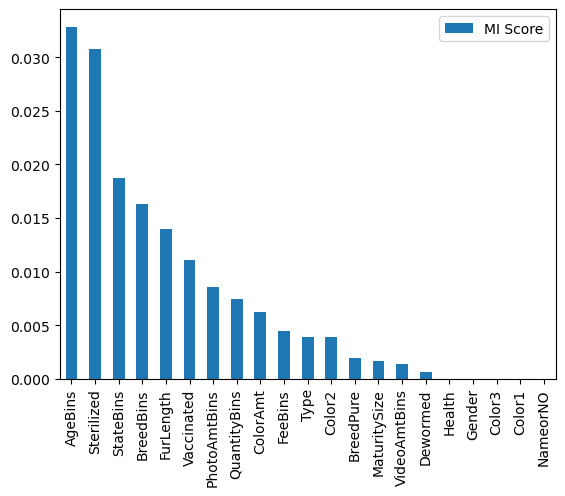

In [264]:
# Only two columns were dropped, let's see if we can reduce the number of columns by considering mutual information gain as well
# Jason Brownlee: "Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable."

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(x_ordinal, y_train)

# Create a DataFrame of the scores
mi_scores = pd.DataFrame(fs.scores_, index=x.columns, columns=['MI Score'])
mi_scores.sort_values(by='MI Score', ascending=False, inplace=True)

# Plot the scores
mi_scores.plot.bar()

# We can try eliminating columns with mutual information score less than 0.005
to_drop = mi_scores.index[mi_scores['MI Score'] < 0.005]
print(to_drop)

In [265]:
# Let's test the performances of feature selected datasets with logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# First, test with the entire dataset

# Hot encode the data because logistic regression assumes that the data is continuous
from sklearn.preprocessing import OneHotEncoder

x_hot_train = x_train.copy()
ohe = OneHotEncoder()
x_hot_train = ohe.fit_transform(x_hot_train)

x_hot_test = x_test.copy()
x_hot_test = ohe.transform(x_hot_test)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train, y_train)

# Make predictions
y_pred = model.predict(x_hot_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.3974658219406469


In [266]:
# Now, test with the feature selected dataset from the chi-squared test
x_train_chi = x_train.drop(['NameorNO', 'ColorAmt'], axis=1)
x_test_chi = x_test.drop(['NameorNO', 'ColorAmt'], axis=1)

x_hot_train_chi = x_train_chi.copy()
x_hot_train_chi = ohe.fit_transform(x_hot_train_chi)

x_hot_test_chi = x_test_chi.copy()
x_hot_test_chi = ohe.transform(x_hot_test_chi)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train_chi, y_train)

# Make predictions
y_pred = model.predict(x_hot_test_chi)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Very similar performance

0.39713237745915303


In [267]:
# Finally, test with the feature selected dataset from the mutual information gain test
x_train_mi = x_train.drop(to_drop, axis=1)
x_test_mi = x_test.drop(to_drop, axis=1)

x_hot_train_mi = x_train_mi.copy()
x_hot_train_mi = ohe.fit_transform(x_hot_train_mi)

x_hot_test_mi = x_test_mi.copy()
x_hot_test_mi = ohe.transform(x_hot_test_mi)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train_mi, y_train)

# Make predictions
y_pred = model.predict(x_hot_test_mi)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Only 0.07% worse than the model with all features - might be worth it to simplify the model and reduce overfitting

0.38979659886628876


In [268]:
# Now let's move on with processing the text data!
text_train_x = df[['Name','Description']].iloc[x_train.index]
text_test_x = df[['Name','Description']].iloc[x_test.index]

print(text_train_x.head())

                    Name                                        Description
4977              Vanila  / Adorable local mix Persian kitten looking fo...
14176          Cliff-ord  Clifford and his 3 siblings need a home. Mothe...
2137   â¥ ..Teddy.. â¥  Introducing Teddy! ♥ Adult male Shih Tzu, 1+ y...
14768               Kiss  Poor Kiss was rescued off a road while he/she ...
14437                Sam  Sam has lots of love to give! He even has a lo...


In [269]:
# The text contains a lot of special characters and some typos that we need to clean up
def clean_text(text):
    text = text.str.lower()
    text = text.str.replace(r'[^a-z\s0-9]', '')
    text = text.str.replace(r'\s+', ' ')
    return text

text_train_x['Name'] = clean_text(text_train_x['Name'])
text_train_x['Description'] = clean_text(text_train_x['Description'])

print(text_train_x.head())

text_test_x['Name'] = clean_text(text_test_x['Name'])
text_test_x['Description'] = clean_text(text_test_x['Description'])

C:\Users\shaol\AppData\Local\Temp\ipykernel_19912\1358091190.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r'[^a-z\s0-9]', '')
C:\Users\shaol\AppData\Local\Temp\ipykernel_19912\1358091190.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r'\s+', ' ')


           Name                                        Description
4977     vanila   adorable local mix persian kitten looking for...
14176  clifford  clifford and his 3 siblings need a home mother...
2137     teddy   introducing teddy adult male shih tzu 1 years ...
14768      kiss  poor kiss was rescued off a road while heshe w...
14437       sam  sam has lots of love to give he even has a lov...


In [278]:
pip install pyspellchecker

   ---------------------------------------- 0.0/6.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.8 MB ? eta -:--:--
   - -------------------------------------- 0.2/6.8 MB 2.4 MB/s eta 0:00:03
   ---- ----------------------------------- 0.8/6.8 MB 6.1 MB/s eta 0:00:01
   ------ --------------------------------- 1.0/6.8 MB 6.6 MB/s eta 0:00:01
   ------ --------------------------------- 1.0/6.8 MB 6.6 MB/s eta 0:00:01
   ------ --------------------------------- 1.0/6.8 MB 6.6 MB/s eta 0:00:01
   ------ --------------------------------- 1.0/6.8 MB 6.6 MB/s eta 0:00:01
   ------ --------------------------------- 1.2/6.8 MB 3.2 MB/s eta 0:00:02
   ---------- ----------------------------- 1.8/6.8 MB 4.4 MB/s eta 0:00:02
   ------------ --------------------------- 2.1/6.8 MB 4.8 MB/s eta 0:00:01
   ------------ --------------------------- 2.1/6.8 MB 4.8 MB/s eta 0:00:01
   ------------ -----------------

In [290]:
from spellchecker import SpellChecker
spell = SpellChecker()

# Find misspelled words
misspelled = set()
for row in text_train_x['Description']:
    if pd.notnull(row):
        words = row.split()
        misspelled = misspelled.union(spell.unknown(words))

print(misspelled)
print(len(misspelled))
# Quite a number of typos!

{'hairshort', 'hurung', 'neuterkan', 'servethis', '4mths', 'rona', 'grayuntuk', 'doreen', 'saleextremely', 'sekaliatau', 'microchipping', 'tiba2', 'bowlfood', 'ashuwat', 'hatinya', 'joanna', 'beradikcomelsihat', 'malaseb', 'kitten1', 'suami', 'superrrrrr', 'kowt', 'alangalang', 'mendengarkan', 'handable', 'ayam', 'lau', 'oneshe', 'smartie', 'siam', 'siti', 'godzi', 'ramadhan', 'nyasekarang', 'parvade', 'adoptpick', 'tuan', 'meowpinklyatcom', 'knowledgei', 'netflix', 'leopandakinai', 'smscall', 'temperamentjust', 'cathe', 'oddeyed', 'belanja', '6blndiberi', 'mugee', 'miko', 'usia', 'sek6', '6gorgeous', 'sweetnatured', 'takda', 'dengan', 'serdang', '10pm', 'adoptwe', 'kejiranan', 'excident', 'gelandangandibuang', 'publics', 'bt', 'sesiapa', 'tgi', 'heydee', 'u5', 'yery', 'lrtkomuter', 'loveanyone', 'liungklang', 'limbed', 'malee', 'ahli', 'herevery', 'monsun', 'semoga', 'poptail', 'rottie', 'pendek', 'boyblack', 'limppony', '10times', 'mimos', 'healthyif', 'makananmakan', 'bik', 'bakamix

In [293]:
# Correct misspelled words with TextBlob
from textblob import TextBlob

def correct_spelling(text):
    if pd.isnull(text):
        return text
    tb = TextBlob(text)
    return str(tb.correct())

text_train_x['Description'] = text_train_x['Description'].apply(correct_spelling)

# Test number of misspelled words again
misspelled = set()
for row in text_train_x['Description']:
    if pd.notnull(row):
        words = row.split()
        misspelled = misspelled.union(spell.unknown(words))

print(misspelled)
print(len(misspelled))

# Number of identified typos reduced from 13005 to 6178
# Here, TextBlob took an extremely long time, about 6 hours...
# Another solution to consider is symspellpy, which claims to six orders of magnitude faster

{'hairshort', 'neuterkan', 'servethis', 'manjapandai', 'grayuntuk', 'sekaliatau', 'saleextremely', 'hanna', 'microchipping', 'goodwatch', 'babyshe', 'bowlfood', 'ashuwat', 'natalya', 'petrovna', 'beradikcomelsihat', 'groomedanything', 'polk', 'll', 'whatssap', 'superrrrrr', 'mendengarkan', 'simon', 'vernon', 'alangalang', 'friendlyquieteasily', '10thmaysome', 'penchala', '11mthdue', 'euthaniasia', 'foodtoilet', 'siam', 'nos', 'puppythe', 'laocoon', 'leukaemia', 'ramadhan', 'nyasekarang', 'adoptpick', 'meowpinklyatcom', 'leopandakinai', 'netflix', 'conditionsdespite', 'temperamentjust', 'temuduga', 'richard', 'ulm', 'ignat', '6blndiberi', 'asmatha', 'everyoneand', 'puppyfemale3', 'sweetnatured', 'firsttime', 'kejiranan', 'putratransportation', 'gelandangandibuang', 'mommydaddy', 'sesiapa', 'lrtkomuter', 'loveanyone', 'liungklang', 'durham', 'limbed', 'ladycat', 'puppynot', 'boyblack', 'limppony', 'brotherblackiehe', 'homezzzzzz', 'makananmakan', 'bakamixed', 'jugakk', 'weekend7mar', 'me

In [294]:
!pip install symspellpy

     ---------------------------------------- 0.0/57.2 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.2 kB ? eta -:--:--
     -------------------------------------- 57.2/57.2 kB 744.9 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.6 MB 14.7 MB/s eta 0:00:01
   ---------------- ----------------------- 1.1/2.6 MB 13.9 MB/s eta 0:00:01
   -------------------------- ------------- 1.7/2.6 MB 13.6 MB/s eta 0:00:01
   ----------------------------------- ---- 2.3/2.6 MB 13.3 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 11.9 MB/s eta

In [ ]:
# Write the new data to a csv file
text_train_x.to_csv('text_train_x.csv', index=False)
text_test_x.to_csv('text_test_x.csv', index=False)
